In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 
import glob

import tqdm

from nd2reader import ND2Reader
import h5py
import pickle
import json

import datetime

from skimage.filters import rank, threshold_otsu, threshold_local#
from skimage import morphology

import plotly


import scipy 
import skimage

import pandas as pd
import seaborn as sns
import csv
from sklearn.cluster import DBSCAN

from tools.func import *
import plotly.express as px

In [2]:
def gen_stats(a):

    ma = a.shape[0]-1

    dist = lambda n,x: np.linalg.norm(np.roll(x,-n,axis=0)-x,axis=-1)
    total_dist = dist(1,a)[...,:-1].sum(axis=-1)
    net_dist = dist(ma,a)[...,0]

    max_dist = np.max([dist(i,a)[...,0] for i in np.arange(ma+1)])
    msd_1 = (dist(1,a)**2)[:-1].mean()

    meandering = net_dist/total_dist
    outreach = max_dist/total_dist

    velocity = lambda n,x: (x-np.roll(x,-n,axis=0))
    velo = velocity(1,a)/np.mean(np.gradient(a[:, -1]))
    instant_velocity = np.abs(velo)
    
    global_turning = np.arctan((np.roll(a,-1,axis=0)[...,-2]-a[...,-2]),(np.roll(a,-1,axis=0)[...,-1]-a[...,-1]))
    dot = lambda x,y: np.einsum('ij,ij->i',x,y)
    relative_turning = np.arccos(dot(np.roll(velo,-1,axis=0),velo)/
                                dot(np.roll(instant_velocity[:,:-1],-1,axis=0),instant_velocity[:,:-1]))
    relative_turning[np.isnan(relative_turning)] = 0
    
    res = np.array([total_dist, net_dist, max_dist, msd_1,meandering, outreach,\
        np.linalg.norm(instant_velocity[:,:-1],axis=-1).mean(),\
        global_turning.mean(),relative_turning.mean(),*a.mean(axis=0)])
        
    return res

In [4]:
df_all = pd.read_csv('./dataStore/ExpDesign2_.csv')  

with open(r"./dataStore/ExpDesig2ID_.pkl", "rb") as input_file:
    contours_dict = pickle.load(input_file)

vars = list(contours_dict[0].keys())[1:]

df_all_ = []
for key_ in contours_dict.keys():
    df_temp = pd.DataFrame()
    for key__ in contours_dict[key_]:
        if key__ in vars:
            df_temp[key__] = contours_dict[key_][key__]
    df_temp["ID_running"] = key_
    df_all_.append(df_temp)
    
df_all_ = pd.concat(df_all_)

with open("./dataStore/vector_tracker_all.pkl", 'rb') as f:
    super_dict = pickle.load(f)


df_ids = pd.read_csv('./dataStore/ExpDesign2_.csv')  
df = pd.read_csv("./dataStore/ExpDesign2_single_.csv")

df = df.loc[:, ['x', 'y', 'z', 'time', 'track_label', 'well_id', 'measurement_id', 'ID_running']]

In [5]:
sub_df = []

for tag, i in df.groupby(['track_label', 'well_id', 'measurement_id', 'ID_running']):

    vel_all = np.sqrt((np.diff(i["x"].values)/np.diff(i["time"].values))**2 + (np.diff(i["y"].values)/np.diff(i["time"].values))**2)
    vel = np.mean(vel_all)
    length = i.shape[0]

    if (6 > length) | (vel < 1e-1):
        continue

    i = i.reset_index(drop=True)
    
    id_ = int(i["ID_running"].values[0])
    id_df = df_ids[df_ids["ID_running"] == id_]

    i["cell_label"] = id_df["cell_label"].values[0]
    i["matrix"] = id_df["matrix"].values[0]

    x = i["x"].values
    y = i["y"].values
    z = i["z"].values
    time = i["time"].values

    dats = np.stack((z,x,y,time), axis = -1)
    out = gen_stats(dats)
    df_stats = pd.DataFrame(out.reshape(1,-1), columns=["total_dist", "net_dist", "max_dist", "msd_1", "outreach", "meandering", "instant_velocity", "global_turning", "relative_turning", "x_mean", "y_mean", "z_mean", "t_mean"])
    
    for k in df_stats.columns:
        i[k] = df_stats[k].values[0]

    sub_df.append(i)

extra =['track_label', 'well_id', 'measurement_id', 'ID_running', 'cell_label', 'matrix']

sub_df = pd.concat(sub_df).reset_index(drop=True)

df_all_tracks = []

for id, tracks in sub_df.groupby(["ID_running", "track_label"]):

    single_data = tracks.reset_index(drop=True)
    spheroid_df = df_all_[df_all_["ID_running"]==id[0]]

    if spheroid_df.shape[0] == 0:
        print("No spheroid in ", id)
        continue

    idx = np.argmin(np.abs(spheroid_df["time"].values - single_data["time"][0]))
    
    if single_data["time"].values[-1] <= spheroid_df["time"].values[-1]:
        end = single_data.shape[0]
        try:
            sub_sub_df = spheroid_df[idx: (idx+end)]
            sub_single = single_data
        except:
            print("Fishy things when matching times: ", id)
            continue
    else:
        #print("spheroid smaller!")
        end = spheroid_df[idx:].shape[0]

        try:
            sub_sub_df = spheroid_df[idx: (idx+end)]
            sub_single = single_data[:end]
        except:
            print("Fishy things when matching times: ", id)
            continue


    if (sub_single.shape[0] < 2) | (sub_sub_df.shape[0] < 2) :
        continue


    dx_single = np.gradient(sub_single["x"].values)
    dy_single = np.gradient(sub_single["y"].values)

    v1 = np.stack((dx_single, dy_single), axis = -1)
    v2 = np.stack((sub_sub_df["x"].values-sub_single["x"].values, sub_sub_df["y"].values-sub_single["y"].values), axis = -1)

    angles_ = np.ones((v2.shape[0],1))*(-1)

    for n in range(v2.shape[0]):
        angles_[n,0] = angle(v1[n,:], v2[n,:])

    deg_angles = np.rad2deg(angles_)

    sub_single["angle"] = deg_angles
    df_all_tracks.append(sub_single)

df_all_tracks = pd.concat(df_all_tracks)
    

mm = df_all_tracks.groupby(['track_label', 'well_id', 'measurement_id', 'ID_running', 'cell_label', 'matrix']).mean().reset_index()
mm2 = mm.groupby(["ID_running"]).size().reset_index(name="counts")

df_all["num_cells"] = -1
num = 0
for run_id, dataFrame in df_all.groupby(["ID_running"]):
    try:
        val = mm2[mm2["ID_running"] == run_id]["counts"].values[0]
    except:
        #print(run_id, ", No detectionsm: ", mm2[mm2["ID_running"] == run_id]["counts"])
        val = 0

    df_all.loc[num, "num_cells"] = val
    num += 1
    
    

In [7]:
df_vec = pd.read_csv("./dataStore/ExpDesign2_vector_.csv")
df_vec = df_vec.loc[:, ['ID_running', 'cell_label', 'well_id', 'measurement_id','matrix', 'protrusion_ID', 'time', 'location', 'x', 'y', 'z', 'x2', 'y2', 'z2', 'length', 'x_vec', 'y_vec', 'angle', 'width']]
#df_vec.columns


df_all_vec = []


for id, vec in df_vec.groupby(["ID_running", "protrusion_ID"]):

    single_data = vec.reset_index(drop=True)
    single_data["rel_angle"] = -1
    spheroid_df = df_all_[df_all_["ID_running"]==id[0]]

    if spheroid_df.shape[0] == 0:
        print("No spheroid in ", id)
        continue

    spheroid_df["dx"] = filter_Gauss(np.gradient(spheroid_df["x"]))
    spheroid_df["dy"] = filter_Gauss(np.gradient(spheroid_df["y"]))

    for k in range(single_data.shape[0]):

        time = int(single_data["time"].values[k])
        row = spheroid_df[spheroid_df["time"] == time]

        if row.shape[0] == 0:
            #print("Time", time, "does not exist in spheroid frame cannot match protrusion, moving on")
            continue

        if row.shape[0]>1:
            print("Too many matches!")
            continue

        v1 = np.stack((row["dx"].values[0], row["dy"].values[0]), axis = -1)
        v2 = np.stack((single_data["x_vec"].values[k], single_data["y_vec"].values[k]), axis = -1)
        angles_ = angle(v1, v2)

        deg_angles = np.rad2deg(angles_)
        #deg_angles = deg_angles[~np.isnan(deg_angles)]
        single_data.loc[k, "rel_angle"] = deg_angles

        df_all_vec.append(single_data)

df_all_vec = pd.concat(df_all_vec)


mm_prot = df_all_vec.groupby(['protrusion_ID', 'well_id', 'measurement_id', 'ID_running', 'cell_label', 'matrix']).mean().reset_index()
mm_prot_2 = mm_prot.groupby(["ID_running"]).size().reset_index(name="counts")

df_all["num_prot"] = -1
num = 0
for run_id, dataFrame in df_all.groupby(["ID_running"]):
    try:
        val = mm_prot_2[mm_prot_2["ID_running"] == run_id]["counts"].values[0]
    except:
        #print(run_id, ", No detections: ", mm_prot_2[mm_prot_2["ID_running"] == run_id]["counts"])
        val = 0

    df_all.loc[num, "num_prot"] = val
    num += 1

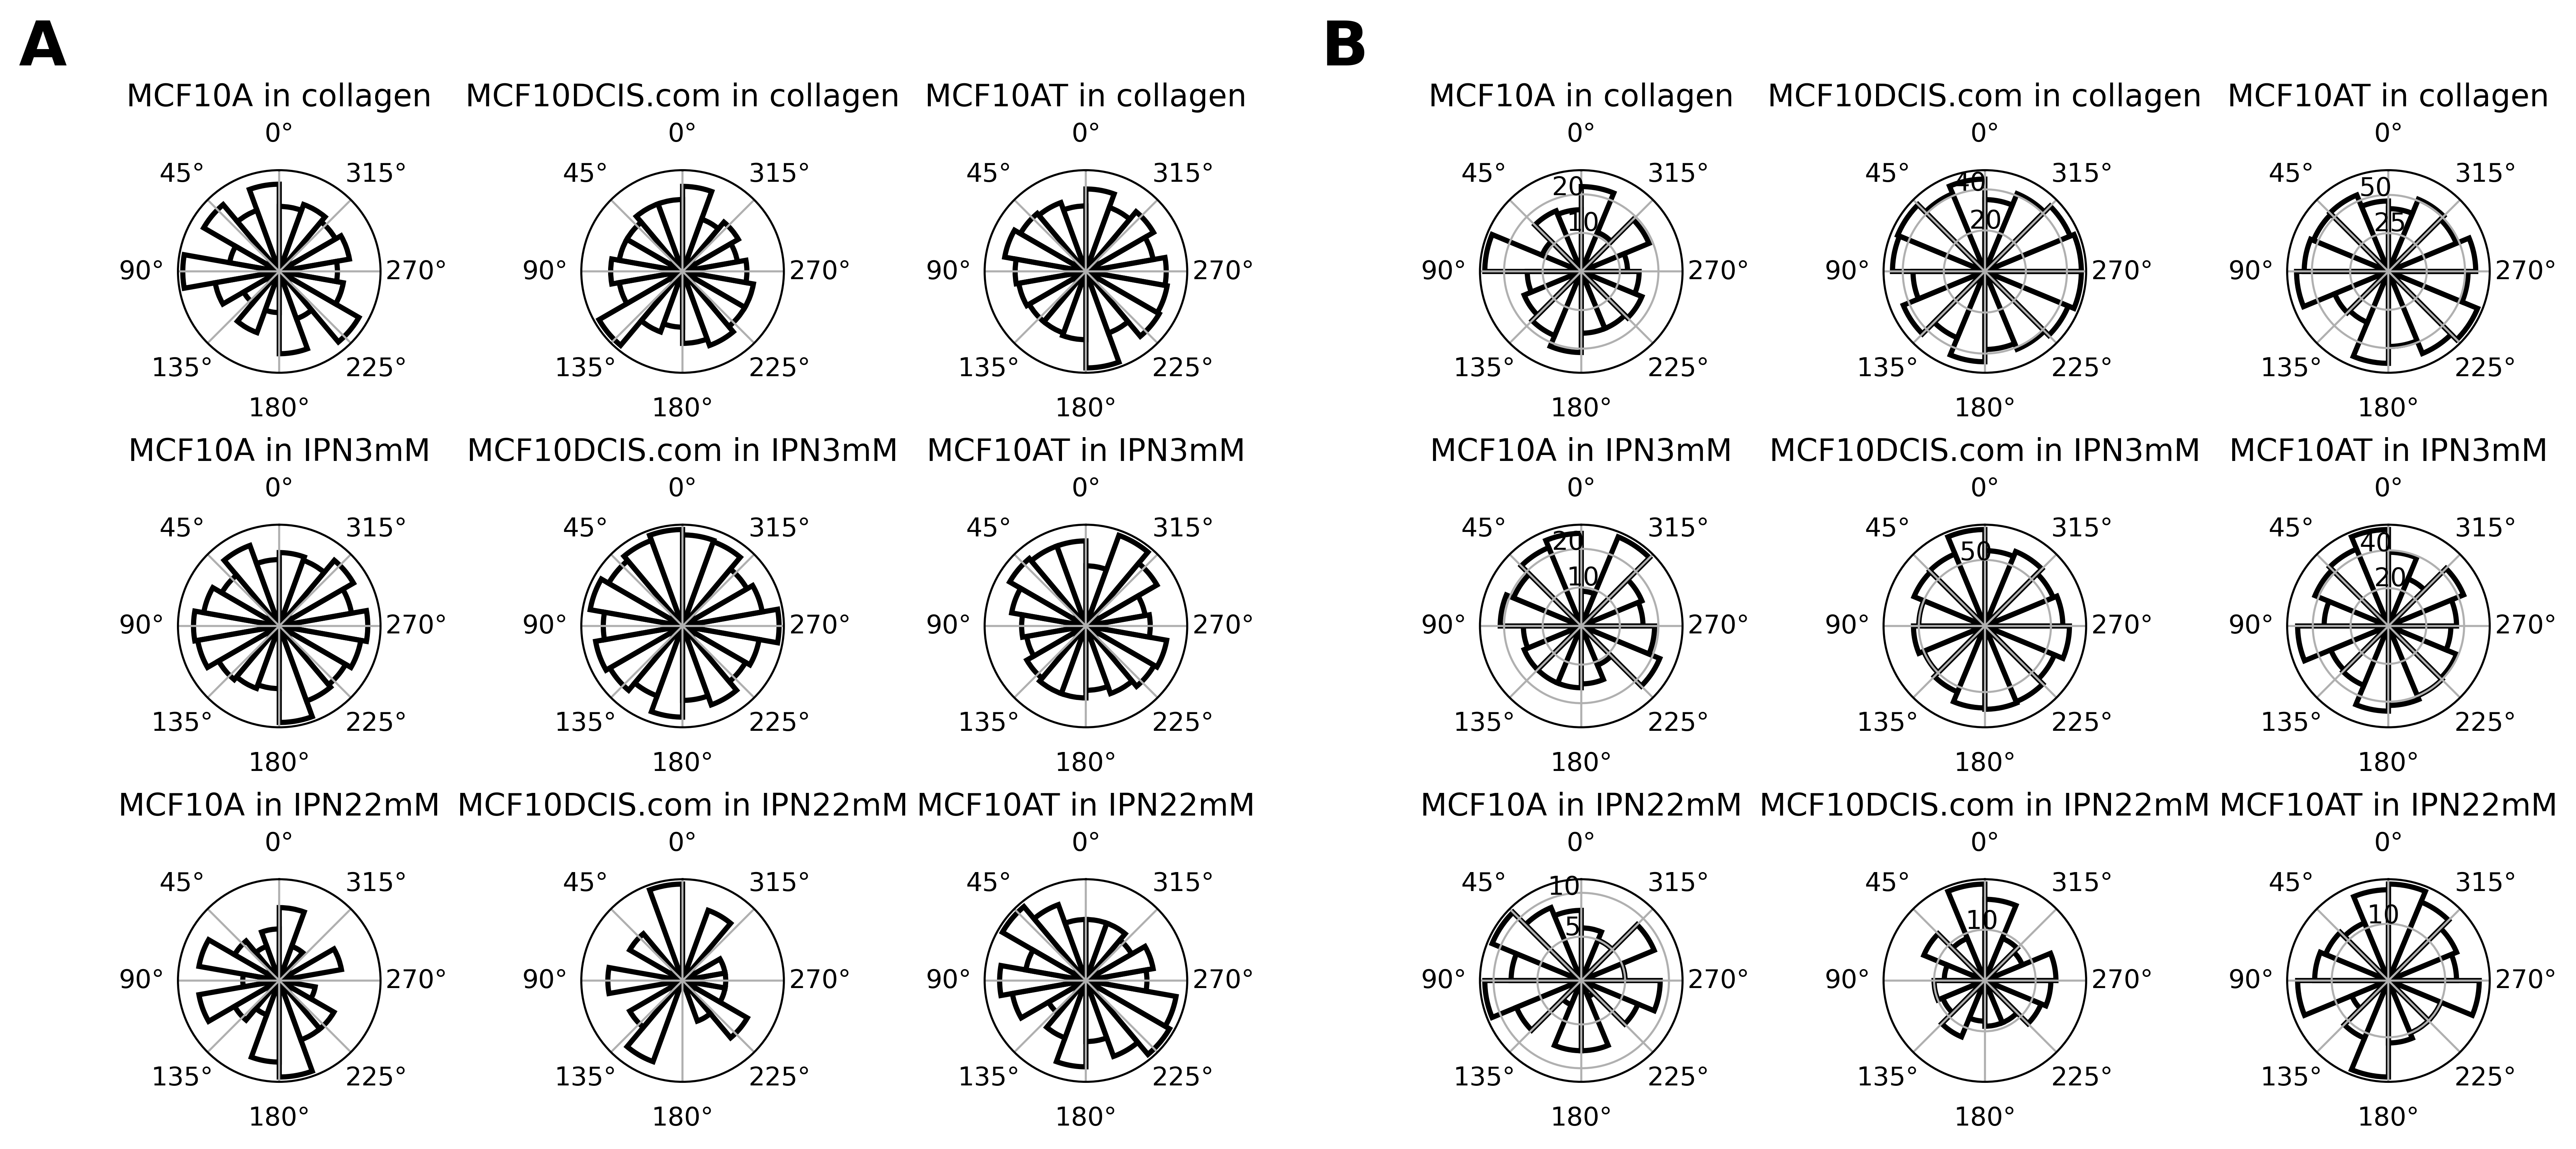

In [29]:
fig = plt.figure(constrained_layout=True, figsize=(14,6),dpi = 500)
subfigs = fig.subfigures(1, 2, wspace=0.0025, hspace=0.0025, width_ratios=[1, 1])

ax0 = subfigs[0].subplots(3, 3,subplot_kw=dict(projection='polar'))
ax1 = subfigs[1].subplots(3, 3,subplot_kw=dict(projection='polar'))

#fig, ax = plt.subplots(3, 3, figsize = (10,8),subplot_kw=dict(projection='polar'))
#fig, ax = plt.subplots(3, 3, figsize = (10,8),subplot_kw=dict(projection='polar'))

row_counter = 0
column_contour = 0

for current_tags, current_data in df_all_tracks.groupby(['matrix', 'cell_label']): #, "measurement_id", "well_id"

    if current_tags[0] == "collagen":
        row_counter = 0
        if current_tags[1] == "MCF10A":
            column_contour = 0
        elif current_tags[1] == "MCF10DCIS.com":
            column_contour = 1
        else:
            column_contour = 2 
    elif current_tags[0] == "IPN3mM":
        row_counter = 1
        if current_tags[1] == "MCF10A":
            column_contour = 0
        elif current_tags[1] == "MCF10DCIS.com":
            column_contour = 1
        else:
            column_contour = 2 
    elif current_tags[0] == "IPN22mM":
        row_counter = 2
        if current_tags[1] == "MCF10A":
            column_contour = 0
        elif current_tags[1] == "MCF10DCIS.com":
            column_contour = 1
        else:
            column_contour = 2 
    else:
        continue

    #current_data = current_data.drop(["level_0"], axis = 1)
    #current_data = current_data.reset_index()
    #current_tags = current_tags

    mean_id = current_data.groupby(["measurement_id", "well_id", "track_label"]).mean(numeric_only=True)["angle"].values

    #print(current_data["ID_running"].unique(), len(mean_id))

    deg_angles = current_data["angle"].values
    deg_angles = deg_angles[~np.isnan(deg_angles)]
    mean_id = mean_id[~np.isnan(mean_id)]

    #circular_hist(ax[row_counter,0], deg_angles, offset=np.pi/2, density=False)
    circular_hist(ax0[row_counter, column_contour], mean_id, offset=np.pi/2, bins = 18, density=True)

    #ax[row_counter,0].title.set_text('{}: All steps'.format(current_tags))
    ax0[row_counter, column_contour].title.set_text('{} in {}'.format(current_tags[1],current_tags[0]))

# Protrusions


row_counter = 0
column_contour = 0

for current_tags, current_data in df_all_vec.groupby(['matrix', 'cell_label']): # "measurement_id", "well_id"
    
    if current_tags[0] == "collagen":
        row_counter = 0
        if current_tags[1] == "MCF10A":
            column_contour = 0
        elif current_tags[1] == "MCF10DCIS.com":
            column_contour = 1
        else:
            column_contour = 2 
    elif current_tags[0] == "IPN3mM":
        row_counter = 1
        if current_tags[1] == "MCF10A":
            column_contour = 0
        elif current_tags[1] == "MCF10DCIS.com":
            column_contour = 1
        else:
            column_contour = 2 
    elif current_tags[0] == "IPN22mM":
        row_counter = 2
        if current_tags[1] == "MCF10A":
            column_contour = 0
        elif current_tags[1] == "MCF10DCIS.com":
            column_contour = 1
        else:
            column_contour = 2 
    else:
        continue

    current_tags = current_tags

    mean_id = current_data.groupby(["measurement_id", "well_id","protrusion_ID"]).mean(numeric_only=True)["rel_angle"].values

    deg_angles = current_data["angle"].values
    deg_angles = deg_angles[~np.isnan(deg_angles)]
    mean_id = mean_id[~np.isnan(mean_id)]

    #circular_hist(ax[row_counter,0], deg_angles, offset=np.pi/2, density=False)
    circular_hist(ax1[row_counter, column_contour], mean_id, offset=np.pi/2, density=False)

    #ax[row_counter,0].title.set_text('{}: All steps'.format(current_tags))
    ax1[row_counter, column_contour].title.set_text('{} in {}'.format(current_tags[1],current_tags[0]))


ax0[0,0].text(-0.55, 1.75, "A", transform=ax0[0,0].transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
ax1[0,0].text(-0.55, 1.75, "B", transform=ax1[0,0].transAxes,fontsize=24, fontweight='bold', va='top', ha='right')

#fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(-0.25, 1.25, 'D')

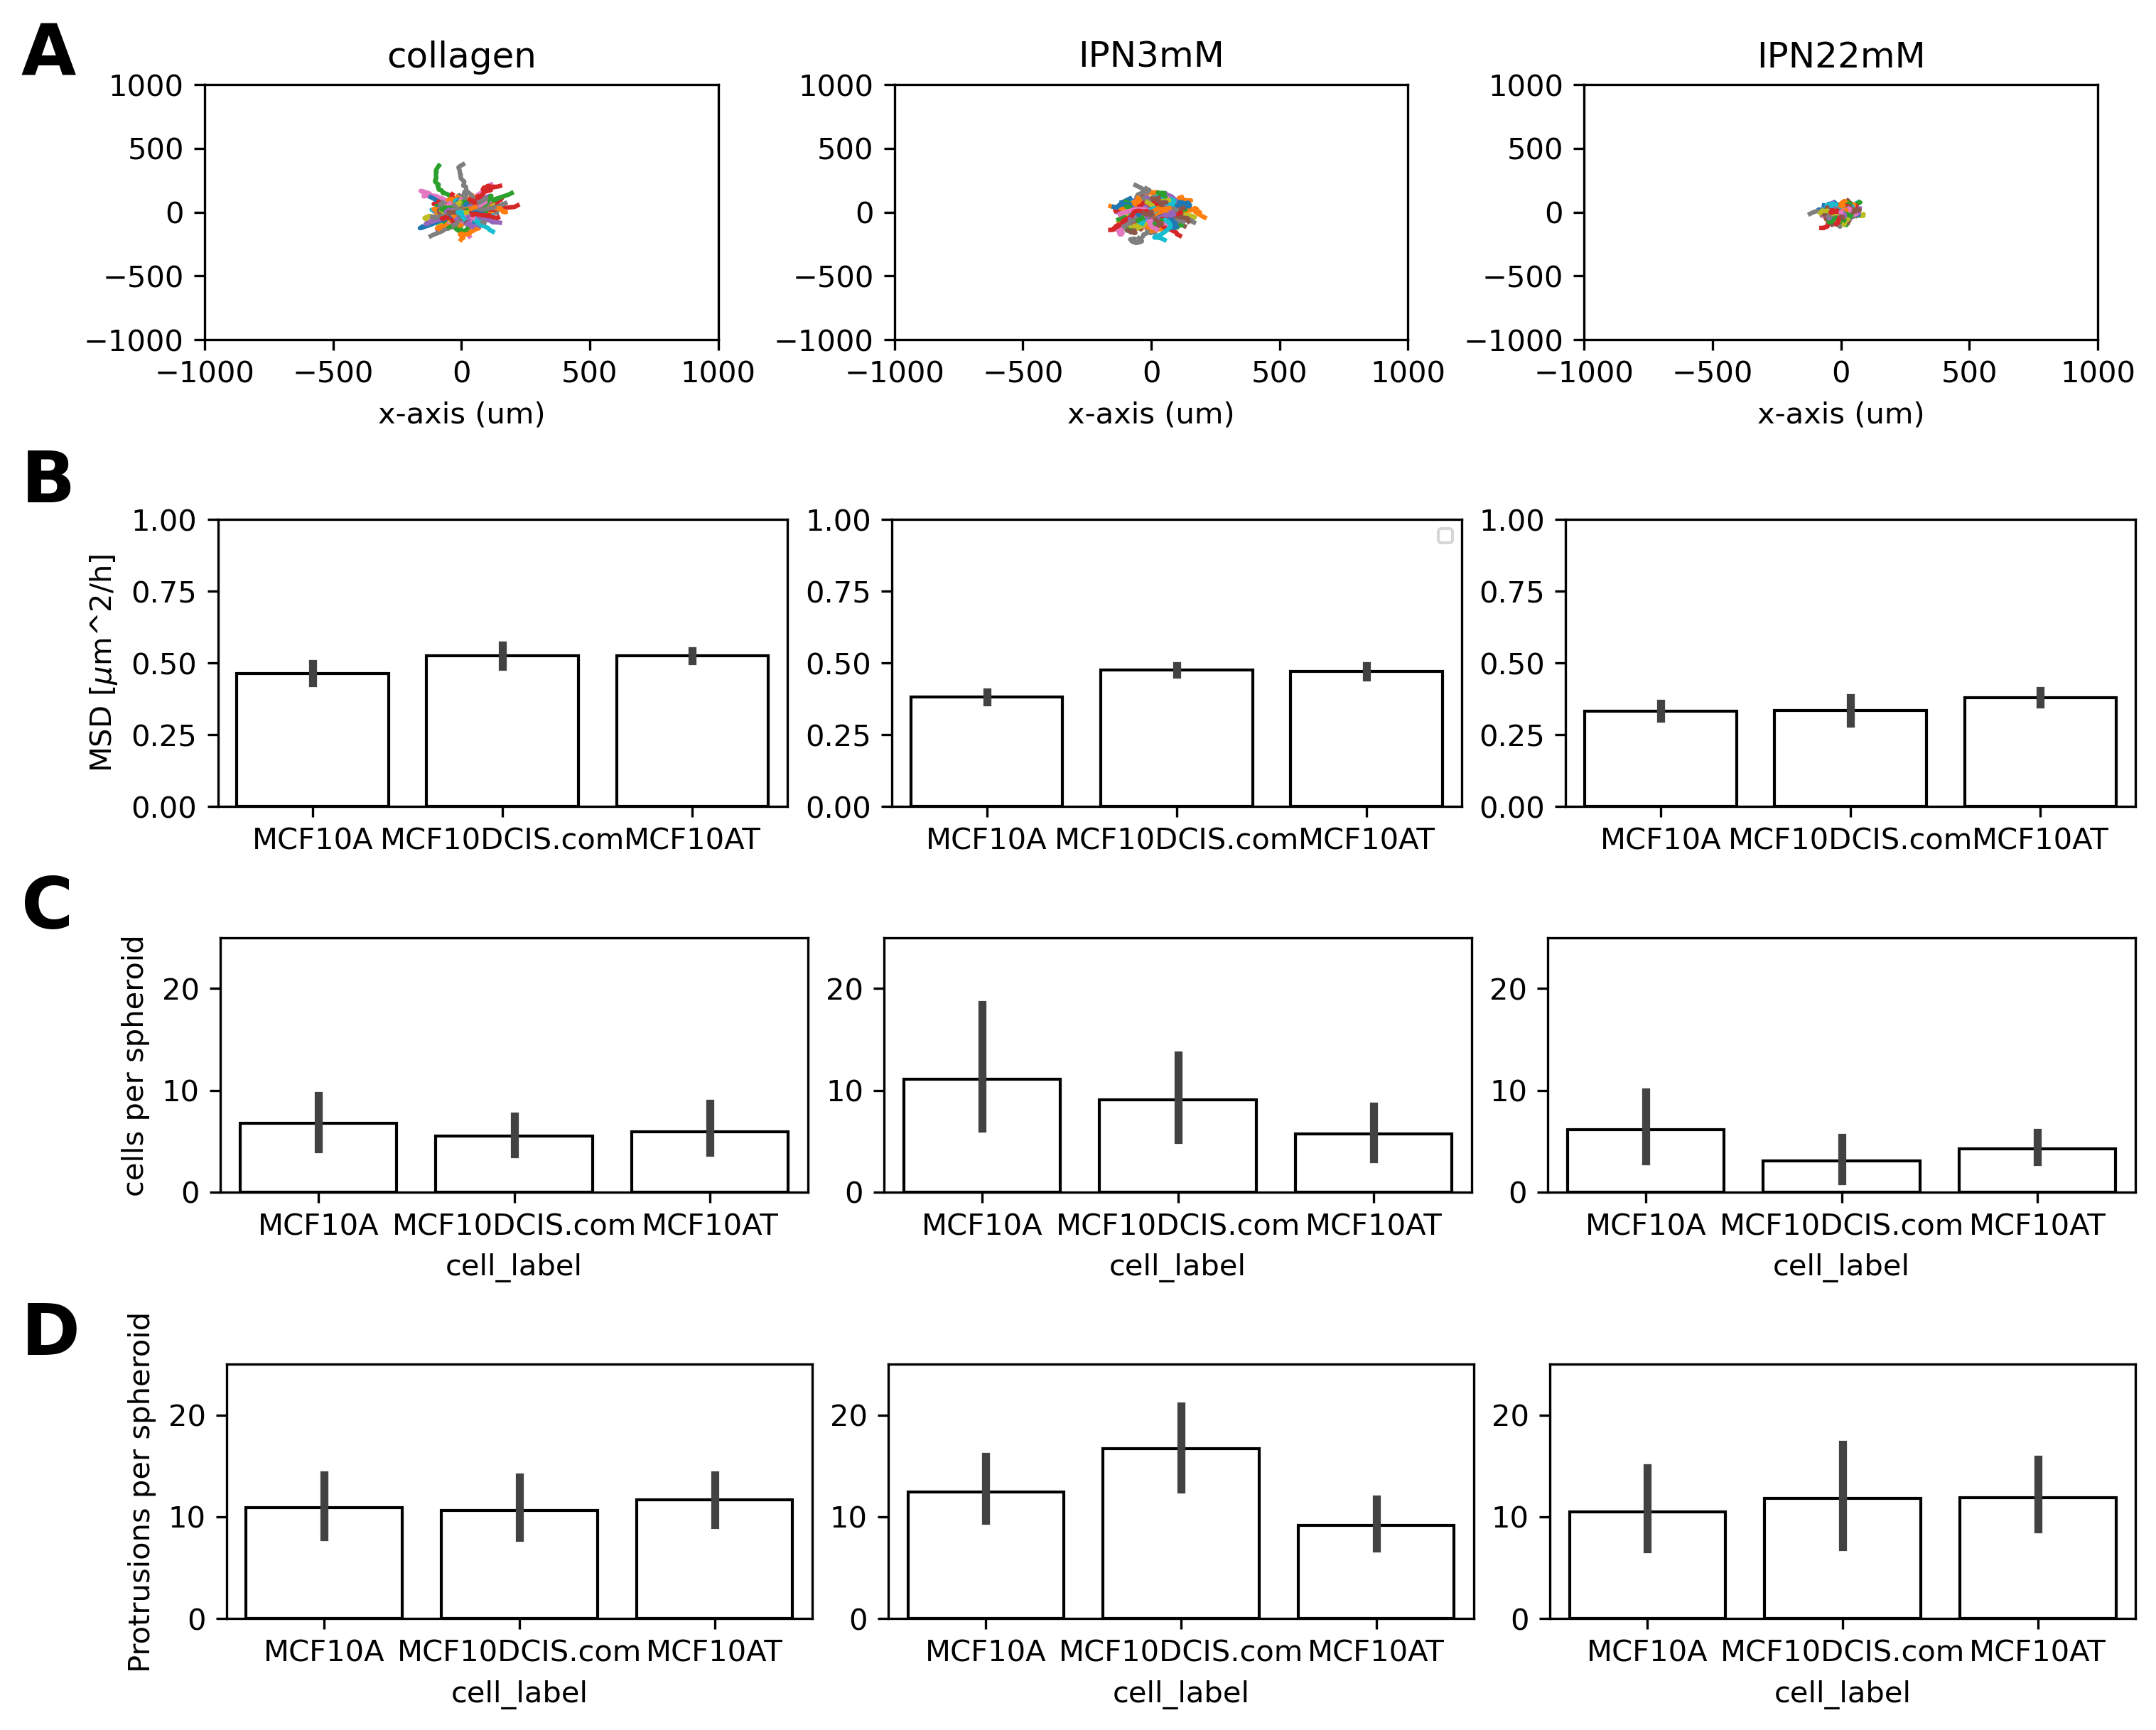

In [35]:

fig = plt.figure(constrained_layout=True, figsize=(10, 8),dpi = 300)
subfigs = fig.subfigures(4, 1, hspace=0.0025) #width_ratios=[1, 1]

ax = [ 
    subfigs[0].add_subplot(131),
    subfigs[0].add_subplot(132),
    subfigs[0].add_subplot(133)
]

for tags, data in df_all_tracks.groupby(extra):
    if tags[-1] == "collagen":
        ax[0].plot(data["x"]-data["x"].values[0],  data["y"]-data["y"].values[0], label = tags[2])
    elif tags[-1] == "IPN3mM":
        ax[1].plot(data["x"]-data["x"].values[0],  data["y"]-data["y"].values[0], label = tags[2])
    elif tags[-1] == "IPN22mM":
        ax[2].plot(data["x"]-data["x"].values[0],  data["y"]-data["y"].values[0], label = tags[2])

    #x_data = np.arange(0,data["t"].values[-1], 10)
    #y_data = power_law(x_data, data["ampltiude"].values[0], data["alpha"].values[0])

ax[0].set_xlabel("x-axis (um)")
ax[1].set_xlabel("x-axis (um)")
ax[2].set_xlabel("x-axis (um)")

ax[0].set_xlim([-1000, 1000 ])
ax[1].set_xlim([-1000, 1000 ])
ax[2].set_xlim([-1000, 1000 ])
ax[0].set_ylim([-1000, 1000 ])
ax[1].set_ylim([-1000, 1000 ])
ax[2].set_ylim([-1000, 1000 ])

ax[0].set_title("collagen")
ax[1].set_title("IPN3mM")
ax[2].set_title("IPN22mM")

ax[0].set_ylabel(r"y-axis ($\mu$m)")
ax[0].set_ylabel(r"")
ax[0].set_ylabel(r"")


ax_1 = [ 
    subfigs[1].add_subplot(131),
    subfigs[1].add_subplot(132),
    subfigs[1].add_subplot(133)
]

#mm = df.groupby(["ID_running", "cell_label", "matrix"]).mean(numeric_only=True).reset_index(drop=False)

for tags, data in mm.groupby(['cell_label', 'matrix']):

    data = data.replace([np.inf, -np.inf], np.nan)
    data.dropna(inplace=True)
    #data = data.groupby(["ID_running", "cell_label"]).mean(numeric_only=True).reset_index(drop=False)

    if tags[-1] == "collagen":
        sns.barplot(x = "cell_label", y = "meandering", data = data, ax = ax_1[0], fill = False, order = ["MCF10A","MCF10DCIS.com","MCF10AT"])
    elif tags[-1] == "IPN3mM":
        sns.barplot(x = "cell_label", y = "meandering", data = data, ax = ax_1[1], fill = False, order = ["MCF10A","MCF10DCIS.com","MCF10AT"])
    elif tags[-1] == "IPN22mM":
        sns.barplot(x = "cell_label", y = "meandering", data = data, ax = ax_1[2], fill = False, order = ["MCF10A","MCF10DCIS.com","MCF10AT"])

ax_1[0].set_xlabel("")
ax_1[1].set_xlabel("")
ax_1[2].set_xlabel("")

ax_1[0].set_ylabel(r'MSD [$\mu$m^2/h]')
ax_1[1].set_ylabel(r'')
ax_1[2].set_ylabel(r'')

ax_1[0].set_ylim([0, 1 ])
ax_1[1].set_ylim([0, 1 ])
ax_1[2].set_ylim([0, 1 ])


ax_1[1].legend(fontsize = 6, loc = "upper right")


ax_2 = [ 
    subfigs[2].add_subplot(131),
    subfigs[2].add_subplot(132),
    subfigs[2].add_subplot(133)
]


for tags, data in df_all.groupby(["matrix"]):
    
    if tags[0] == "collagen":
        sns.barplot(x = "cell_label", y = "num_cells", data = data, ax = ax_2[0], fill = False, order = ["MCF10A","MCF10DCIS.com","MCF10AT"])
    elif tags[0] == "IPN3mM":
        sns.barplot(x = "cell_label", y = "num_cells", data = data, ax = ax_2[1], fill = False, order = ["MCF10A","MCF10DCIS.com","MCF10AT"])
    elif tags[0] == "IPN22mM":
        sns.barplot(x = "cell_label", y = "num_cells", data = data, ax = ax_2[2], fill = False, order = ["MCF10A","MCF10DCIS.com","MCF10AT"])
    else:
        print("False label: ", tags)
#print(ct)
ax_2[0].set_ylabel(r'cells per spheroid')
ax_2[1].set_ylabel(r'')
ax_2[2].set_ylabel(r'')
ax_2[0].set_ylim([0, 25 ])
ax_2[1].set_ylim([0, 25 ])
ax_2[2].set_ylim([0, 25 ])

ax_3 = [ 
    subfigs[3].add_subplot(131),
    subfigs[3].add_subplot(132),
    subfigs[3].add_subplot(133)
]

for tags, data in df_all.groupby(["matrix"]):
    
    if tags[0] == "collagen":
        sns.barplot(x = "cell_label", y = "num_prot", data = data, ax = ax_3[0], fill = False, order = ["MCF10A","MCF10DCIS.com","MCF10AT"])
    elif tags[0] == "IPN3mM":
        sns.barplot(x = "cell_label", y = "num_prot", data = data, ax = ax_3[1], fill = False, order = ["MCF10A","MCF10DCIS.com","MCF10AT"])
    elif tags[0] == "IPN22mM":
        sns.barplot(x = "cell_label", y = "num_prot", data = data, ax = ax_3[2], fill = False, order = ["MCF10A","MCF10DCIS.com","MCF10AT"])
    else:
        print("False label: ", tags)
#print(ct)
ax_3[0].set_ylabel(r'Protrusions per spheroid')
ax_3[1].set_ylabel(r'')
ax_3[2].set_ylabel(r'')
ax_3[0].set_ylim([0, 25 ])
ax_3[1].set_ylim([0, 25 ])
ax_3[2].set_ylim([0, 25 ])

ax[0].text(-0.25, 1.25, "A", transform=ax[0].transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
ax_1[0].text(-0.25, 1.25, "B", transform=ax_1[0].transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
ax_2[0].text(-0.25, 1.25, "C", transform=ax_2[0].transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
ax_3[0].text(-0.25, 1.25, "D", transform=ax_3[0].transAxes,fontsize=24, fontweight='bold', va='top', ha='right')


In [24]:
df.isnull().sum(axis = 0)

total_dist          0
net_dist            0
max_dist            0
msd_1               0
outreach            0
meandering          0
instant_velocity    0
global_turning      0
relative_turning    0
dtype: int64

In [25]:
import numpy as np
from sklearn.decomposition import PCA

uni_ = ["total_dist", "net_dist", "max_dist", "msd_1", "outreach", "meandering", "instant_velocity", "global_turning", "relative_turning"]

df = sub_df.loc[:,uni_]
df = (df-df.min())/(df.max()-df.min())

pca = PCA(n_components=3,whiten = True)
pca = pca.fit(df)
components = pca.fit_transform(df)
comp = pd.DataFrame(components, columns = ['1','2','3'])

extra =['track_label', 'time', 'well_id', 'measurement_id', 'ID_running', 'cell_label', 'matrix']

for i in extra:
    comp[i] = sub_df[i]

total_var = pca.explained_variance_ratio_.sum() * 100

print(pca.singular_values_)


[82.11166313 48.37956626 38.62220314]


[Text(0, 0, 'total_dist'),
 Text(1, 0, 'net_dist'),
 Text(2, 0, 'max_dist'),
 Text(3, 0, 'msd_1'),
 Text(4, 0, 'outreach'),
 Text(5, 0, 'meandering'),
 Text(6, 0, 'instant_velocity'),
 Text(7, 0, 'global_turning'),
 Text(8, 0, 'relative_turning')]

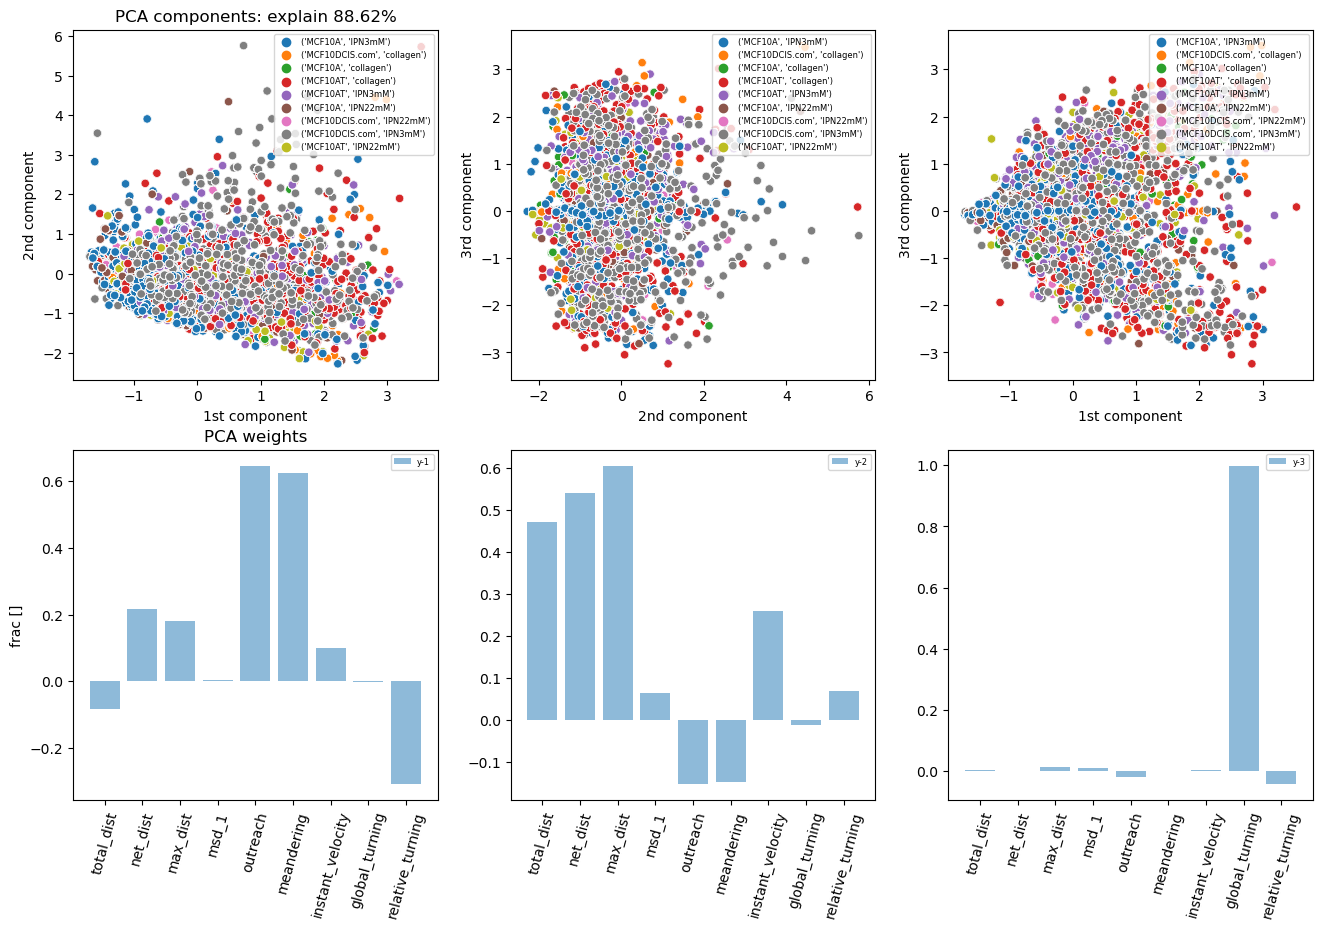

In [33]:
fig, ax = plt.subplots(2, 3,figsize=(16, 10),facecolor='white')


name = ax[0,0].set_title("PCA components: explain {:.2f}%".format(total_var))
ax[0,0].set_xlabel("1st component")
ax[0,0].set_ylabel("2nd component")
sns.scatterplot(x='1', y='2', data=comp, ax = ax[0,0], hue = comp[["cell_label", 'matrix']].apply(tuple, axis=1)) # 
ax[0,0].legend(loc='upper right',fontsize=6)

ax[0,1].set_xlabel("2nd component")
ax[0,1].set_ylabel("3rd component")
sns.scatterplot(x='2', y='3', data=comp, ax = ax[0,1],  hue = comp[["cell_label", 'matrix']].apply(tuple, axis=1))
ax[0,1].legend(loc='upper right',fontsize=6)

ax[0,2].set_xlabel("1st component")
ax[0,2].set_ylabel("3rd component")
sns.scatterplot(x='1', y='3', data=comp, ax = ax[0,2],  hue = comp[["cell_label", 'matrix']].apply(tuple, axis=1))
ax[0,2].legend(loc='upper right',fontsize=6)

weights = pca.components_

ax[1,0].set_title("PCA weights")
ax[1,0].bar(uni_,weights[0,:], label = "y-1", alpha = 0.5)
#ax[1,0].bar(np.arange(0,len(weights[0,1::2])),weights[0,1::2], label = "y-1", alpha = 0.5)
ax[1,0].legend(fontsize=6)

ax[1,1].bar(uni_,weights[1,:], label = "y-2", alpha = 0.5)
#ax[1,1].bar(np.arange(0,len(weights[0,1::2])),weights[1,1::2], label = "y-2", alpha = 0.5)
ax[1,1].legend(fontsize=6)

ax[1,2].bar(uni_,weights[2,:], label = "y-3", alpha = 0.5)
#ax[1,2].bar(np.arange(0,len(weights[0,1::2])),weights[2,1::2], label = "y-3", alpha = 0.5)
ax[1,2].legend(fontsize=6)

ax[1,0].set_ylabel("frac []")

ax[1,0].set_xticklabels(uni_, rotation=75)
ax[1,1].set_xticklabels(uni_, rotation=75)
ax[1,2].set_xticklabels(uni_, rotation=75)
